#### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
# torch.set_printoptions(sci_mode=False, )
np.set_printoptions(suppress=True)

from clonaltrans import pl, utils
import os

%load_ext autoreload
%autoreload 2

#### Some Explorations 

In [3]:
paga, array_total = utils.get_topo_obs('./data/')

Topology graph loaded (11, 11).
Input cell data (num_timepoints 3, num_clones 10, num_populations 11) loaded.
Day0 has been added. Input data shape: torch.Size([4, 10, 11])
Background reference cells generated. Input data shape: torch.Size([4, 11, 11])


In [4]:
paga

tensor([[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [5]:
array_total[0]

tensor([[ 85.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 75.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 68.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 65.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 60.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 55.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 48.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 45.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 31.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [550.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],
       device='cuda:0')

In [8]:
(array_total.sum(0) != 0).to(torch.float32).unsqueeze(0).shape

torch.Size([1, 11, 11])

#### Test

In [ ]:
from clonaltrans import main, config

config = config.Configuration()
config.learning_rate = 0.01
config.num_epochs = 1000
config.lrs_step = 200
config.lrs_gamma = 0.5

model = main.run_model(config, torch.tensor([0.0, 3.0, 10.0, 17.0]))

In [ ]:
torch.save(model, './model.pt')

#### Evaluate

In [7]:
path = './examples/Time4LR001Epo750MultiLRNSoftPlus1e-5.pt'
model = torch.load(path)
device = torch.device(f"cuda:{model.config.gpu}")

There are 3 observed timepoints except the inital time.


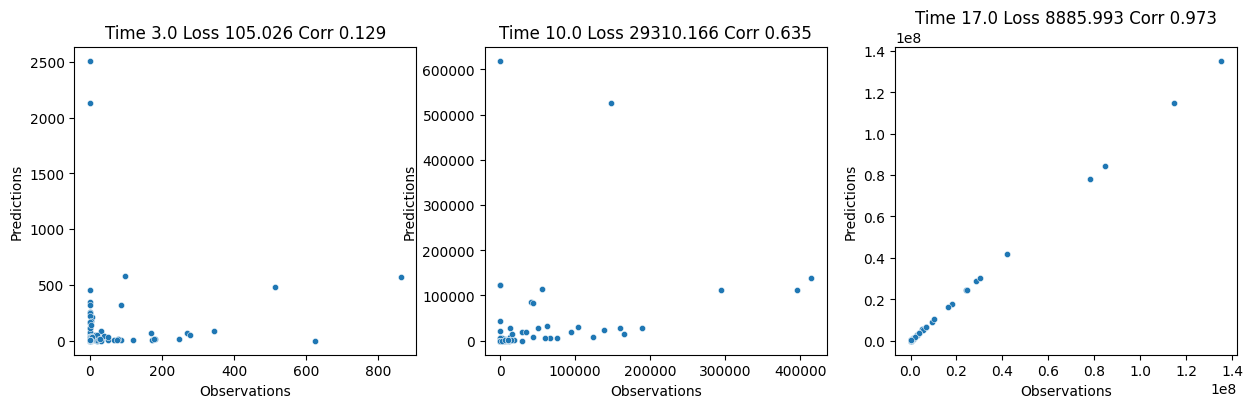

In [8]:
t_observed = torch.tensor([0.0, 3.0, 10.0, 17.0]).to(device)
save = 'eval_' + os.path.split(path)[1]
pl.eval_predictions(model, t_observed, save=save)

#### Timepoints Smoothing

In [9]:
t_observed = torch.tensor([0.0, 3.0, 10.0, 17.0]).to(device)

x = np.linspace(0, 17, 100)
t_pred = torch.tensor(x).to(device)
t_pred_norm = (t_pred - t_pred[0]) / (t_pred[-1] - t_pred[0])
predictions = model.eval_model(t_pred_norm)

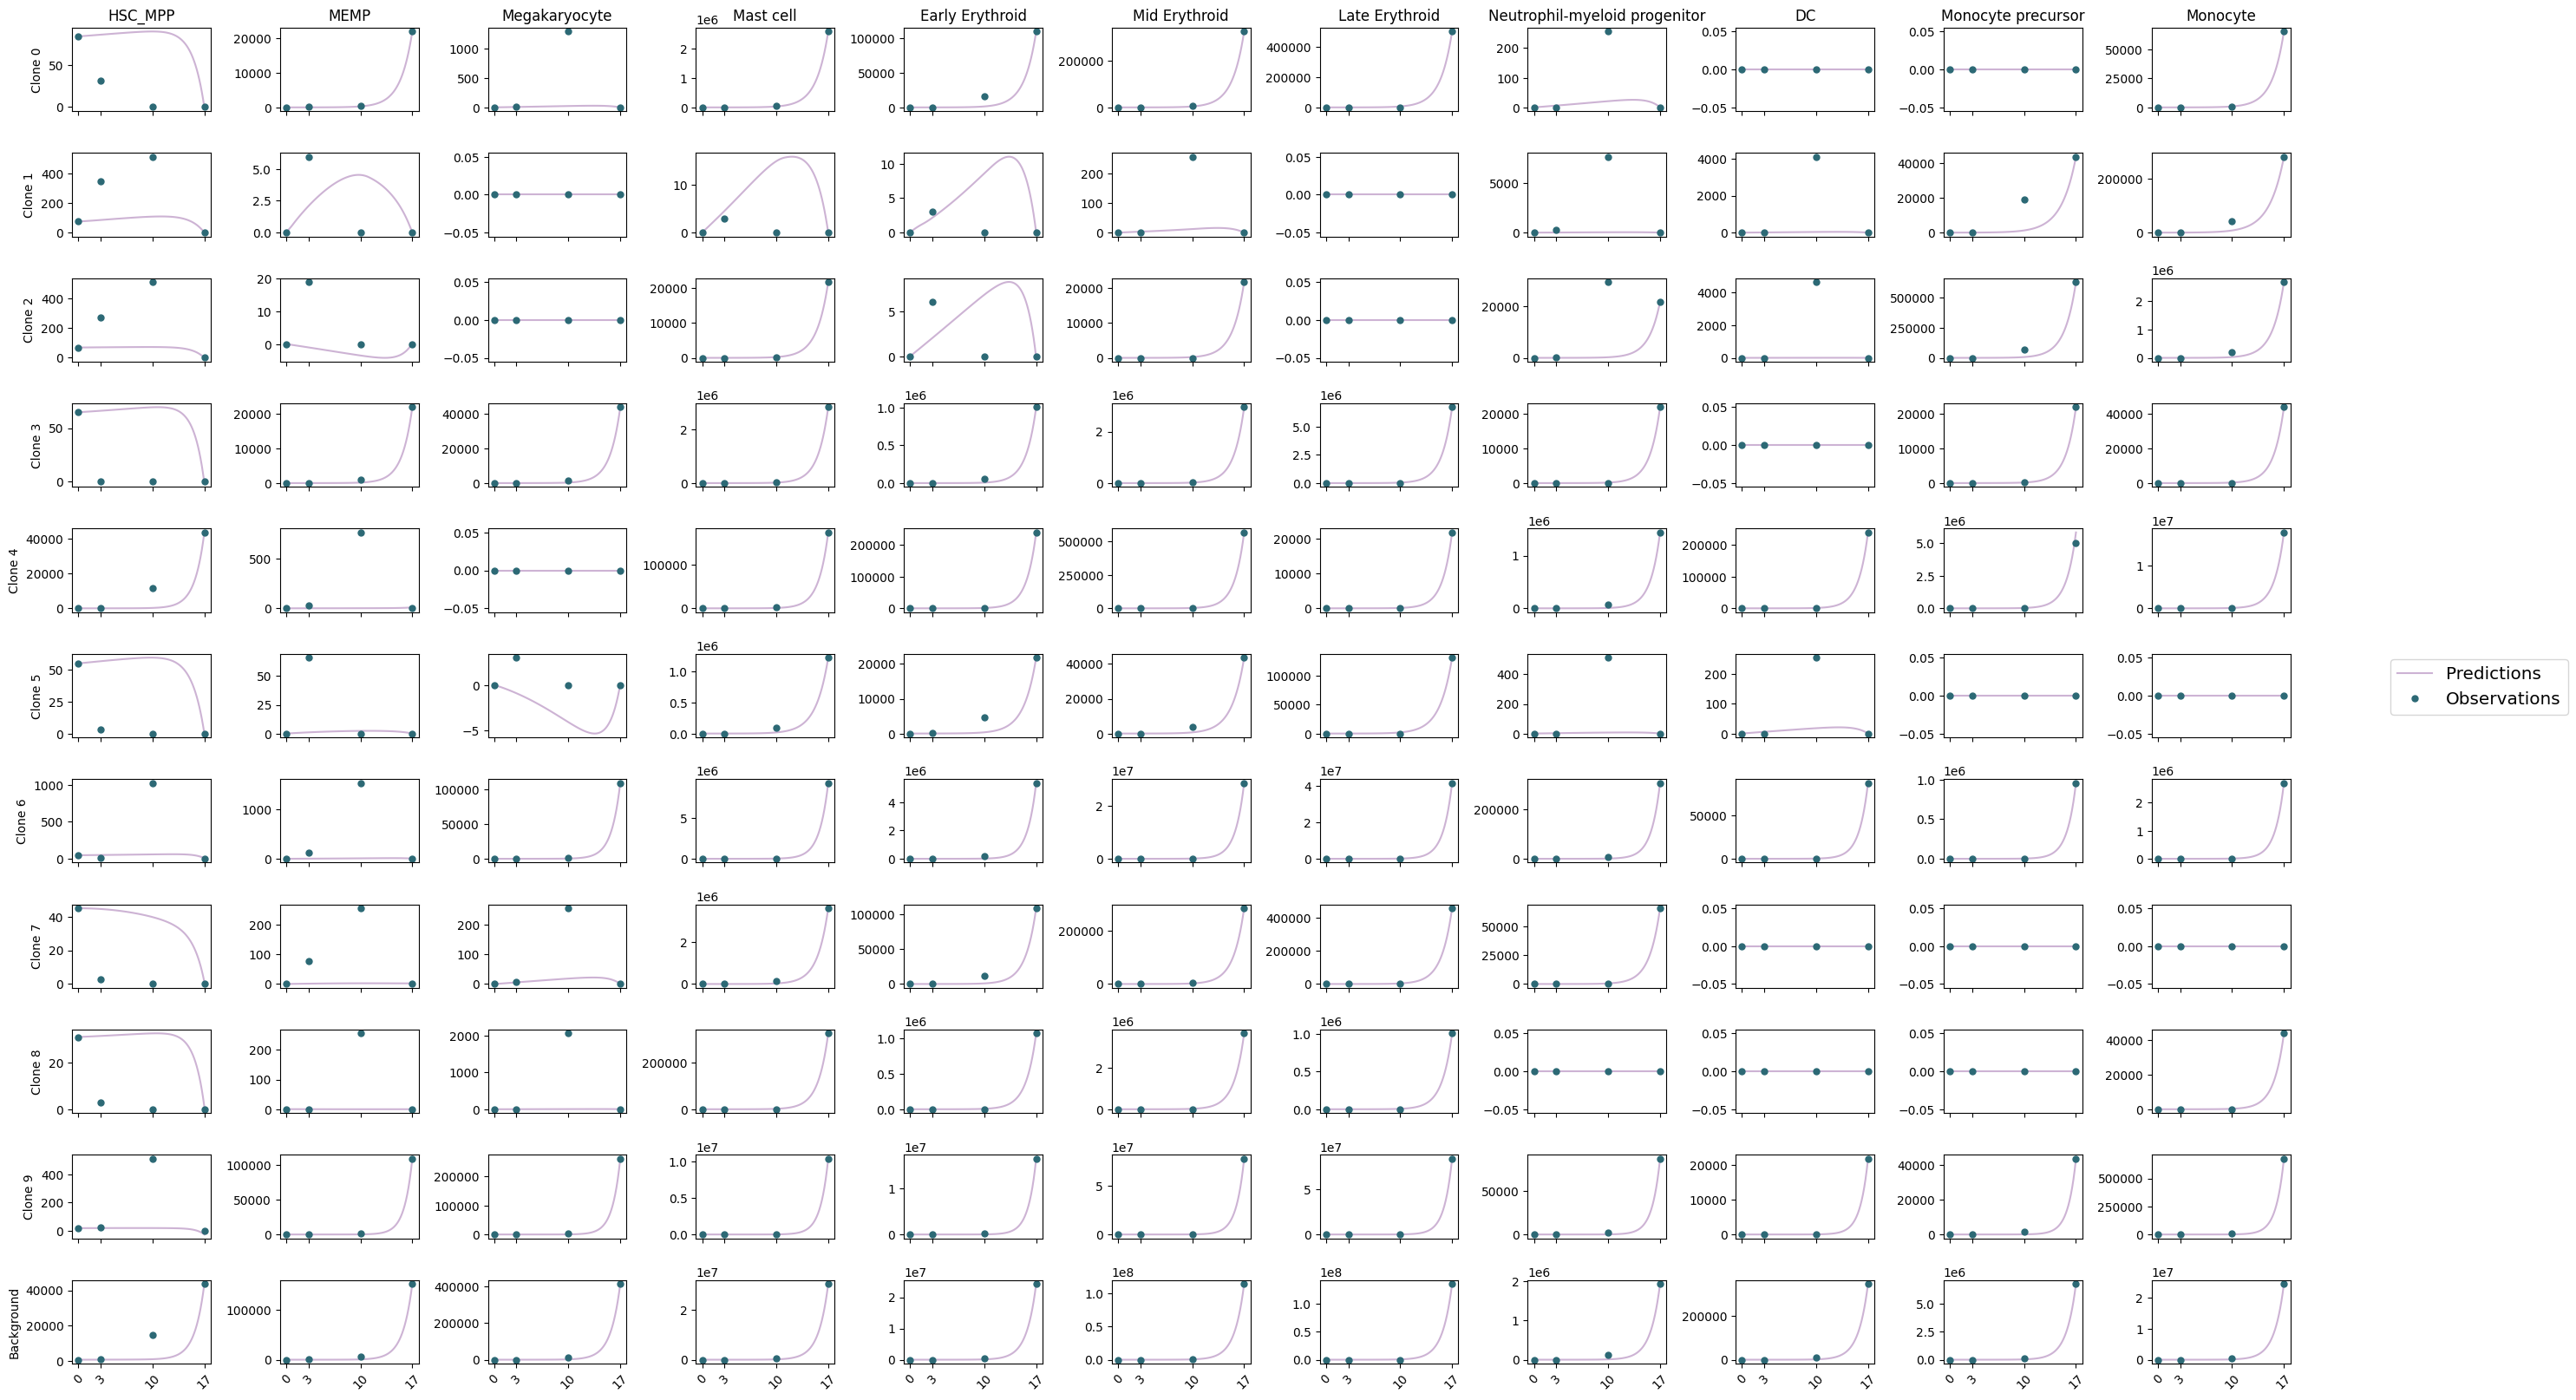

In [10]:
save = os.path.split(path)[1]
pl.grid_visual_interpolate(model.N, predictions, t_observed, t_pred, save=save)

#### Analysis

In [11]:
K = model.matrix_K

In [12]:
anno = pd.read_csv('./data/annotations.csv')

In [13]:
transition_K = pd.DataFrame(
    index=anno['populations'].values, 
    columns=anno['populations'].values, 
    data=K.detach().cpu().numpy()[-1]
)

<AxesSubplot: >

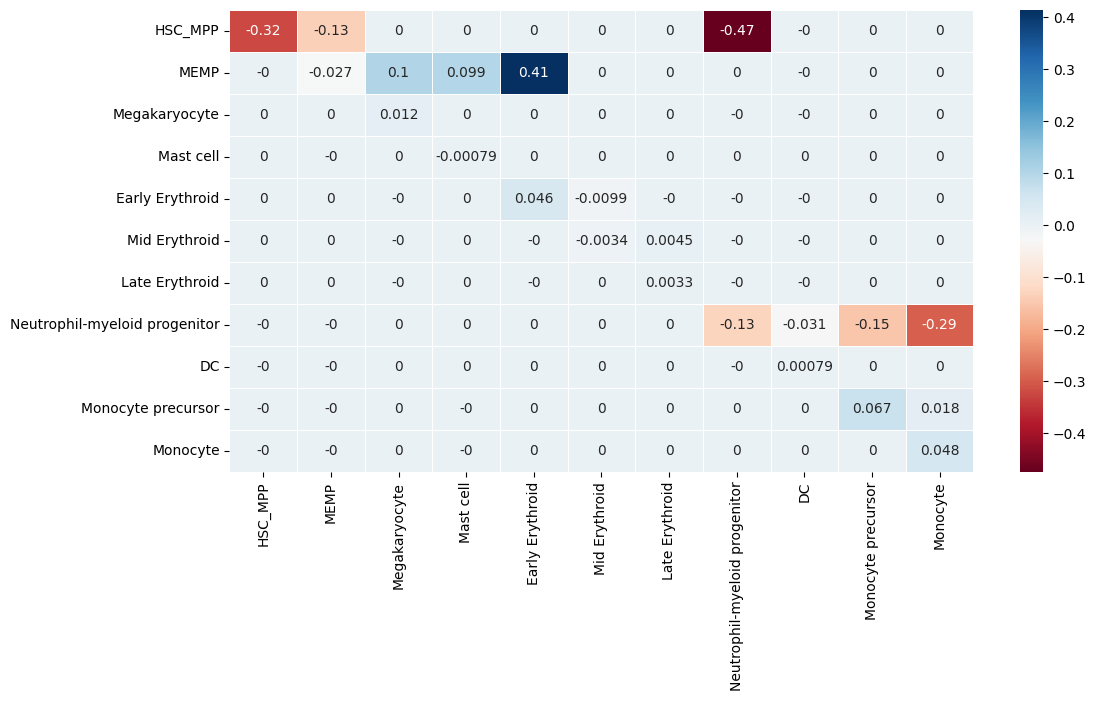

In [14]:
fig, axes = plt.subplots(figsize=(12, 6))
sns.heatmap(transition_K, annot=True, linewidths=.5, cmap='RdBu', ax=axes)